# 1. Dependencies

In [1]:
!pip install torch torchvision torchaudio
!pip install stable-baselines3[extra] protobuf==3.20.*
!pip install mss pydirectinput pytesseract

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
#chrome://dino/

In [3]:
# Screen capture faster than OpenCV
from mss import mss
# Sending commands (wasd)
import pydirectinput
# Frame processing
import cv2
# Transforming
import numpy as np
# OCR for 'game over' extraction
# OCR: Optical Character Recognition
import pytesseract
# Visualize captured frames
from matplotlib import pyplot as plt
import time
# Env components
from gym import Env
from gym.spaces import Box, Discrete

# 2. Environment

In [4]:
class WebGame(Env):
    
    # Setup env, action, and obs shapes
    def __init__(self):
        # Subclass model
        super().__init__()
        # Spaces
        # Box is a freeform shape (in our instance an array)
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70}
    
    def step(self, action):
        # Action key(s): 0 for Spacebar (up), 1 for Duck (down), 2 for No Action (no operation)
        action_map = {
            0:'space',
            1:'down',
            2:'no_op'
        }
        
        if action != 2:
            pydirectinput.press(action_map[action])
            
        # Checking if game is done
        done, done_cap = self.get_done()
        # Get newest observation
        new_observation = self.get_observation()
        # Reward system: Dino gets a point for every frame that he is alive
        reward = 1
        # Info dictionary
        info = {}
        
        return new_observation, reward, done, info
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        
        # If user hits 'q' on their keyboard, close the frame
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
    
    # Restart the game
    def reset(self):
        # Give time to reset
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
        
        return self.get_observation()
    
    # Closes the obs
    def close(self):
        cv2.destroyAllWindows()
    
    # Capture a region of the game that we can use
    def get_observation(self):
        # Get screen capture of the game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (100,83))
        # Add channels first to match what stable baseline parameters are
        channel = np.reshape(resized, (1,83,100))
        
        return channel
    
    # Get the 'game over' text that is displayed on the screen using OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # Valid done text
        done_strings = ['GAME', 'GAHE']
        
        # Apply OCR
        done = False
        # Grabs the first four letters
        res = pytesseract.image_to_string(done_cap)[:4]
        
        if res in done_strings:
            done = True
        
        return done, done_cap

In [5]:
env = WebGame()
#env.action_space.sample()

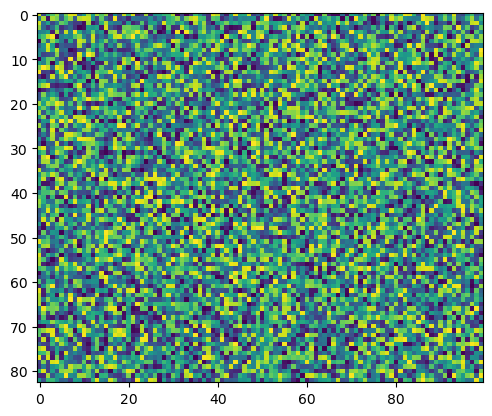

In [6]:
plt.imshow(env.observation_space.sample()[0])

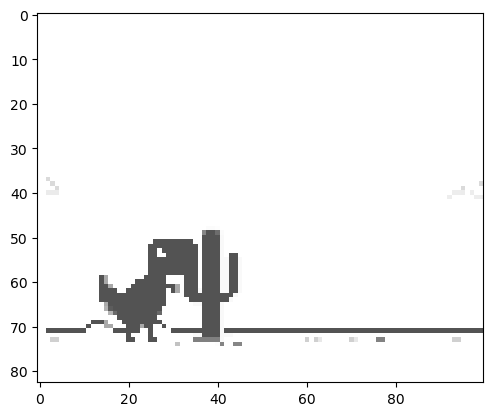

In [7]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [8]:
env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [9]:
#done, done_cap = env.get_done()
#print(done)

In [10]:
#plt.imshow(done_cap)

In [11]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

# 3. Train the Model

In [16]:
# File management
import os 
# Saving models
from stable_baselines3.common.callbacks import BaseCallback
# Environment    
from stable_baselines3.common import env_checker

In [19]:
env_checker.check_env(env)

TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.

In [20]:
# Save our model every x number of steps
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [ ]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=1000000, save_path=CHECKPOINT_DIR)

In [21]:
# Deep-Q Network
from stable_baselines3 import DQN

In [ ]:
# Buffer size: Depends on the memory of the device that is running it
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=600000, learning_starts=1000)

In [ ]:
model.learn(total_timesteps=2000000, callback=callback)

# 4. Test the Model

In [ ]:
model = DQN.load(os.path.join('best_model_88000'))

In [ ]:
for episode in range(50):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        # Unpacking
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward)) 